# US Inflation Forecasting - Exploratory Data Analysis

---

## Project Overview

This notebook performs comprehensive exploratory analysis to identify optimal lag structures for macroeconomic predictors of US inflation. The analysis employs:

- **Stationarity Testing:** Augmented Dickey-Fuller tests
- **Autocorrelation Analysis:** ACF/PACF diagnostics
- **Cross-Correlation Function (CCF):** Data-driven lag selection across 25 periods

**Key Variables:**
- **Target:** CPI Year-over-Year Inflation Rate
- **Predictors:** WTI Crude Oil, Unemployment Rate, M2 Money Supply

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
from fredapi import Fred
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from dotenv import load_dotenv
import os

from scipy.stats import pearsonr

## 2. Data Collection from FRED

Loading monthly inflation data from the Federal Reserve Economic Data API.

**Series:** CPIAUCSL - Consumer Price Index for All Urban Consumers  
**Calculation:** 12-month percentage change  
**Fixed End Date:** January 01, 2025 (for reproducibility)

In [2]:
load_dotenv()
fred = Fred(api_key=os.getenv('FRED_API_KEY'))
cpi = fred.get_series('CPIAUCSL', observation_end='2025-01-01')
inflation = cpi.pct_change(periods = 12) * 100 
inflation.dropna(inplace = True)
inflation_df = pd.DataFrame(inflation, columns=['inflation'])
inflation_df.index.name = 'date'
inflation_df.head(10)                                                                                                                                                                                                                                                   

,inflation
date,
1948-01-01,10.242086
1948-02-01,9.481961
1948-03-01,6.818182
1948-04-01,8.272727
1948-05-01,9.384966
1948-06-01,9.375000
1948-07-01,9.761583
1948-08-01,9.062500
1948-09-01,6.654991


### 2.1 Visualize Inflation Time Series

/var/folders/3s/r8gqdd0d04xdvr0f7g1hb2r00000gn/T/ipykernel_14109/1761437488.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


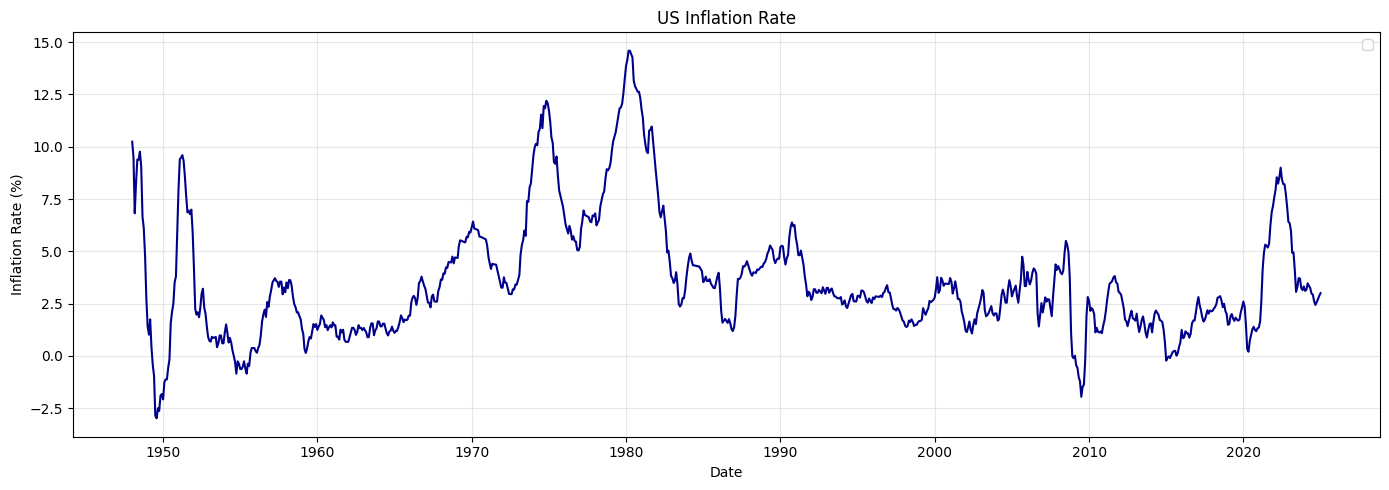

INFLATION SUMMARY STATISTIC

Mean: 3.53%
Std Dev: 2.89%
Min: -2.99%
Max: 14.59%


In [3]:
plt.figure(figsize=(14, 5))
plt.plot(inflation_df.index, inflation_df['inflation'], color= 'darkblue')
plt.title('US Inflation Rate')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


print("INFLATION SUMMARY STATISTIC\n")
print(f"Mean: {inflation_df['inflation'].mean():.2f}%")
print(f"Std Dev: {inflation_df['inflation'].std():.2f}%")
print(f"Min: {inflation_df['inflation'].min():.2f}%")
print(f"Max: {inflation_df['inflation'].max():.2f}%")

## 3. Autocorrelation Analysis - Inflation

### 3.1 ACF/PACF on Raw Inflation Data

Examining autocorrelation patterns to:
- Detect seasonality (12-month cycle expected)
- Identify potential AR and MA orders

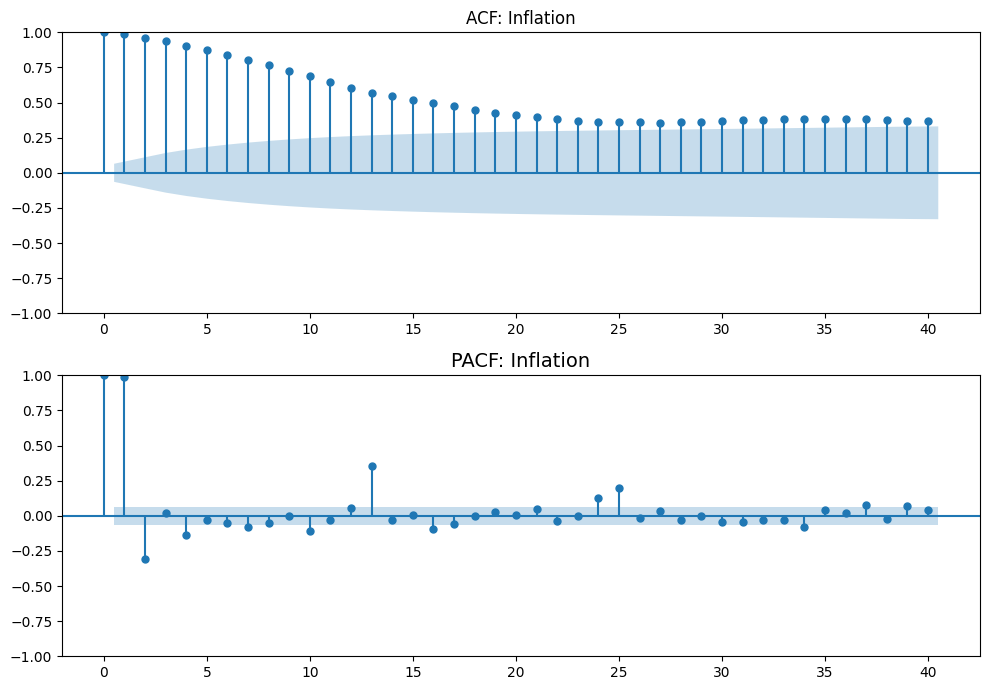

In [4]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7))

plot_acf(inflation_df['inflation'], lags=40, ax=axes[0])
axes[0].set_title('ACF: Inflation')
plot_pacf(inflation_df['inflation'], lags=40, ax=axes[1])
axes[1].set_title('PACF: Inflation', fontsize=14)
plt.tight_layout()
plt.show()

### 3.2 ACF/PACF on Differenced Inflation

Applying first-order differencing to remove trend and assess stationarity.

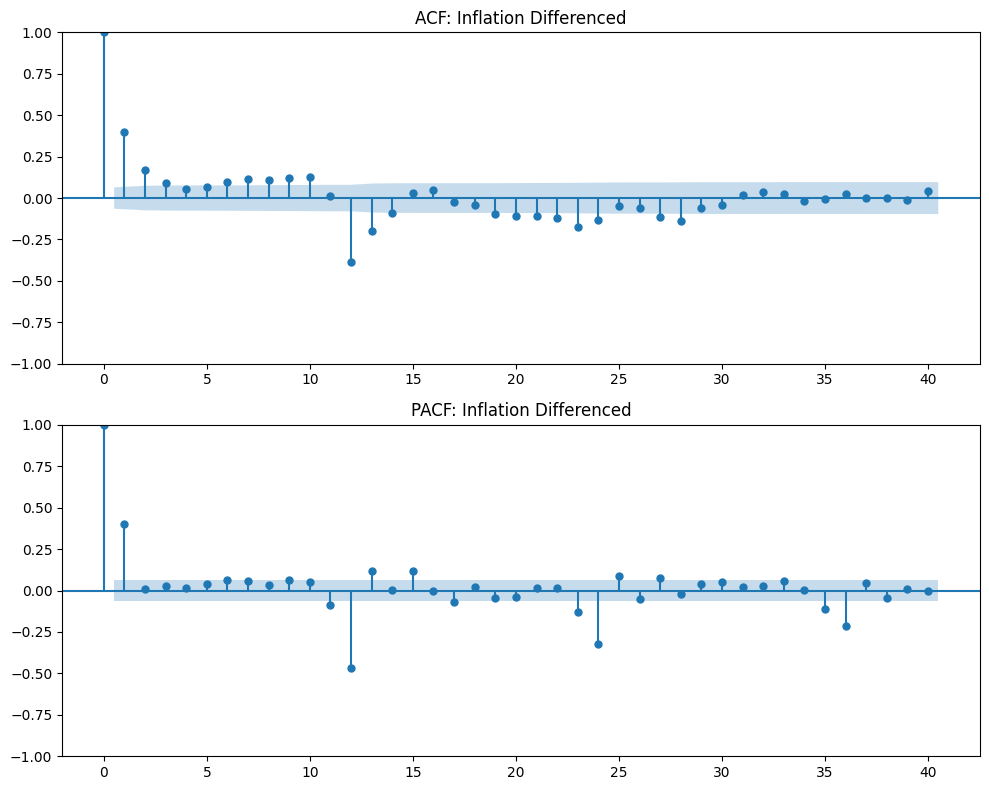

In [5]:
inflation_diff = inflation_df['inflation'].diff().dropna()

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(inflation_diff, lags=40, ax=axes[0])
axes[0].set_title('ACF: Inflation Differenced')
plot_pacf(inflation_diff, lags=40, ax=axes[1])
axes[1].set_title('PACF: Inflation Differenced')
plt.tight_layout()
plt.show()

## 4. Load Exogenous Variables

- **Oil Prices (DCOILWTICO)**
  - Cost-push inflation from energy costs

- **Unemployment (UNRATE)**
  - Phillips curve - demand-pull inflation

- **M2 Money Supply (M2SL)**
  - Monetary inflation transmission



In [6]:
oil = fred.get_series('DCOILWTICO', observation_end='2025-01-01') 
unemployment = fred.get_series('UNRATE', observation_end='2025-01-01')    
m2 = fred.get_series('M2SL', observation_end='2025-01-01')

exo_df = pd.DataFrame({'oil': oil, 'unemployment': unemployment, 'm2': m2})
exo_df = exo_df.resample('ME').last()  
exo_df.index.name = 'date'

inflation_exo = pd.concat([inflation_df, exo_df], axis=1)
inflation_exo.ffill(inplace=True)
inflation_exo.dropna(inplace=True)

inflation_exo.head(10)


,inflation,oil,unemployment,m2
date,,,,
1986-01-31,3.973510,18.95,6.7,2502.1
1986-02-01,3.198495,18.95,6.7,2502.1
1986-02-28,3.198495,13.23,7.2,2512.9
1986-03-01,2.153558,13.23,7.2,2512.9
1986-03-31,2.153558,10.25,7.2,2533.1
1986-04-01,1.588785,10.25,7.2,2533.1
1986-04-30,1.588785,13.38,7.1,2557.8
1986-05-01,1.679104,13.38,7.1,2557.8
1986-05-31,1.679104,14.30,7.2,2584.8


### 4.1 Visualize All Economic Indicators

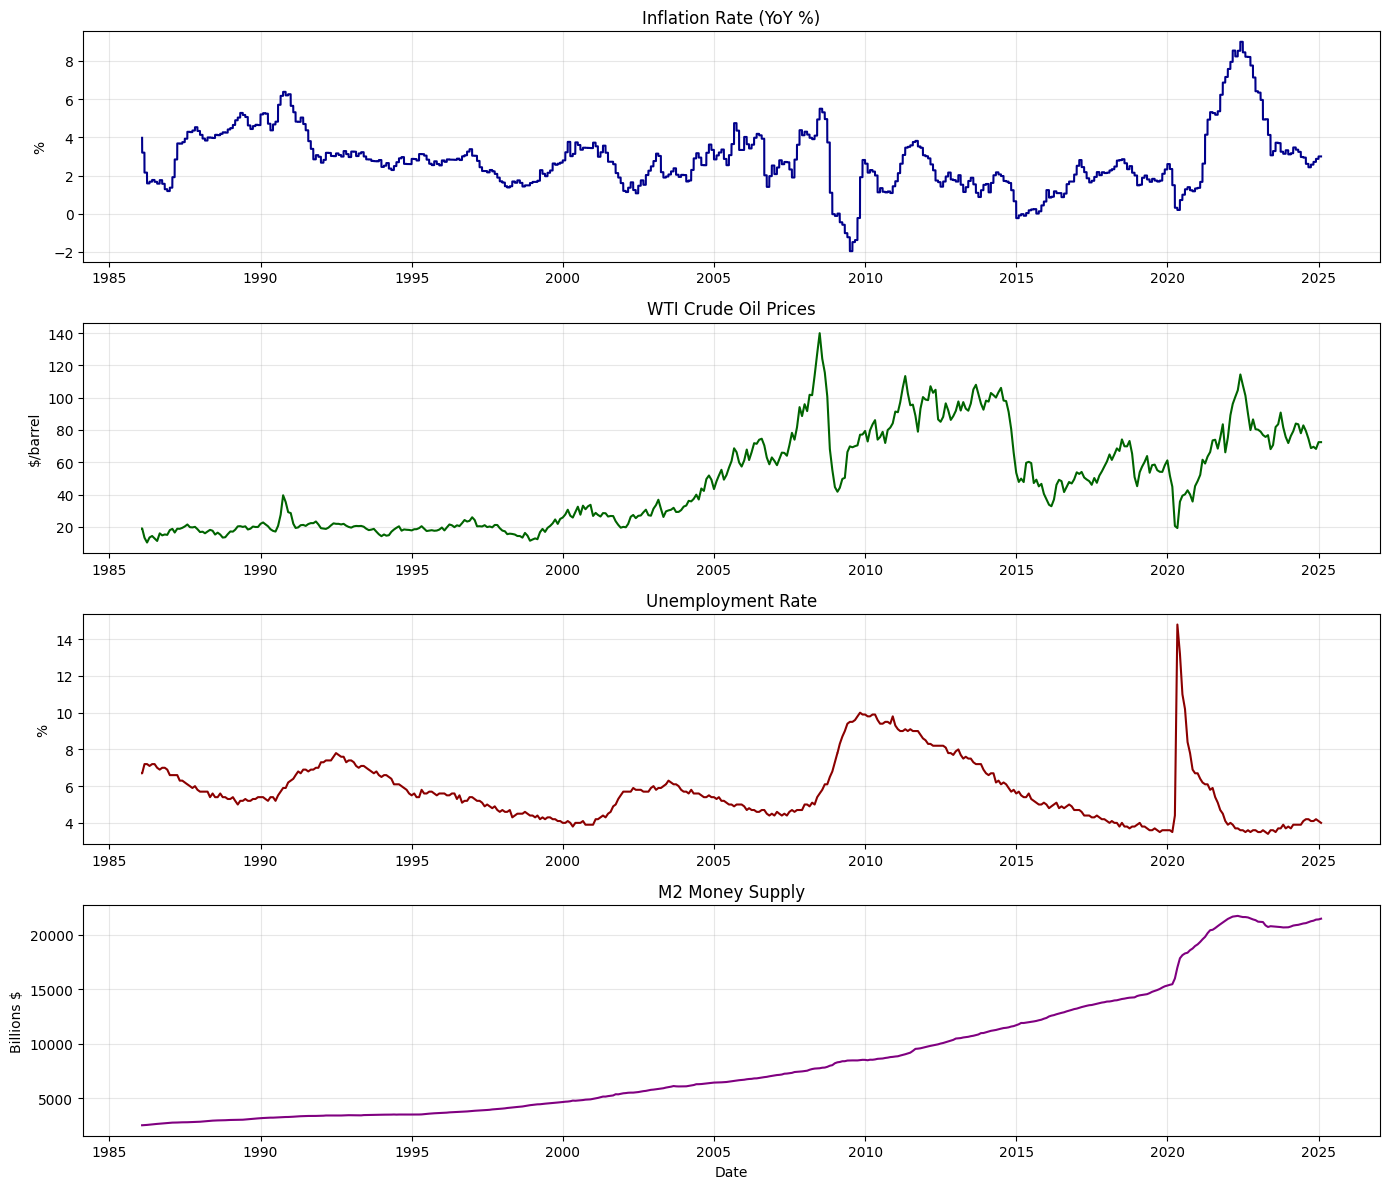

In [7]:
fig, axes = plt.subplots(4, 1, figsize=(14, 12))

axes[0].plot(inflation_exo.index, inflation_exo['inflation'], color='darkblue')
axes[0].set_title('Inflation Rate (YoY %)')
axes[0].set_ylabel('%')
axes[0].grid(alpha=0.3)

axes[1].plot(inflation_exo.index, inflation_exo['oil'], color='darkgreen')
axes[1].set_title('WTI Crude Oil Prices')
axes[1].set_ylabel('$/barrel')
axes[1].grid(alpha=0.3)

axes[2].plot(inflation_exo.index, inflation_exo['unemployment'], color='darkred')
axes[2].set_title('Unemployment Rate')
axes[2].set_ylabel('%')
axes[2].grid(alpha=0.3)

axes[3].plot(inflation_exo.index, inflation_exo['m2'], color='purple')
axes[3].set_title('M2 Money Supply')
axes[3].set_ylabel('Billions $')
axes[3].set_xlabel('Date')
axes[3].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Stationarity Testing - Original Variables

### Augmented Dickey-Fuller Tests

Testing null hypothesis: Series has a unit root (non-stationary)

**Decision Rule:**
- p-value < 0.05 → Series is stationary
- p-value ≥ 0.05 → Series is non-stationary (needs differencing)

In [8]:
adf_oil = adfuller(inflation_exo['oil'])
print(f'ADF Statistic for oil: {adf_oil[0]:.3f}')
print(f'p-value for oil: {adf_oil[1]:.3f}\n')

adf_unemployment = adfuller(inflation_exo['unemployment'])
print(f'ADF Statistic for unemployment: {adf_unemployment[0]:.3f}')
print(f'p-value for unemployment: {adf_unemployment[1]:.3f}\n')

adf_m2 = adfuller(inflation_exo['m2'])
print(f'ADF Statistic for m2: {adf_m2[0]:.3f}')
print(f'p-value for m2: {adf_m2[1]:.3f}')

ADF Statistic for oil: -2.394
p-value for oil: 0.143

ADF Statistic for unemployment: -2.855
p-value for unemployment: 0.051

ADF Statistic for m2: 1.125
p-value for m2: 0.995


## 6. Variable Transformation

Based on ADF test results:

- **Oil (p=0.14):** Non-stationary
- **M2 (p=0.995):** Highly non-stationary
- **Unemployment (p=0.051):** Stationary 

In [9]:
inflation_exo['oil_diff'] = inflation_exo['oil'].diff() 
inflation_exo['m2_diff'] = inflation_exo['m2'].diff()
inflation_exo.dropna(inplace=True)  

inflation_exo.head(10)

,inflation,oil,unemployment,m2,oil_diff,m2_diff
date,,,,,,
1986-02-01,3.198495,18.95,6.7,2502.1,0.00,0.0
1986-02-28,3.198495,13.23,7.2,2512.9,-5.72,10.8
1986-03-01,2.153558,13.23,7.2,2512.9,0.00,0.0
1986-03-31,2.153558,10.25,7.2,2533.1,-2.98,20.2
1986-04-01,1.588785,10.25,7.2,2533.1,0.00,0.0
1986-04-30,1.588785,13.38,7.1,2557.8,3.13,24.7
1986-05-01,1.679104,13.38,7.1,2557.8,0.00,0.0
1986-05-31,1.679104,14.30,7.2,2584.8,0.92,27.0
1986-06-01,1.767442,14.30,7.2,2584.8,0.00,0.0


### 6.1 Verify Stationarity After Differencing

Confirming that differencing successfully induced stationarity.

In [10]:
adf_oil_diff = adfuller(inflation_exo['oil_diff'])
print(f'ADF Statistic for oil difference: {adf_oil_diff[0]:.3f}')
print(f'p-value for oil difference: {adf_oil_diff[1]:.3f}\n')

adf_m2_diff = adfuller(inflation_exo['m2_diff'])
print(f'ADF Statistic for m2 difference: {adf_m2_diff[0]:.3f}') 
print(f'p-value for m2 difference: {adf_m2_diff[1]:.3f}')   

ADF Statistic for oil difference: -17.651
p-value for oil difference: 0.000

ADF Statistic for m2 difference: -3.641
p-value for m2 difference: 0.005


**Result:** Both oil_diff and m2_diff are now strongly stationary (p < 0.01)

## 7. Autocorrelation Analysis - Exogenous Variables

### 7.1 Oil Price Differenced - ACF/PACF

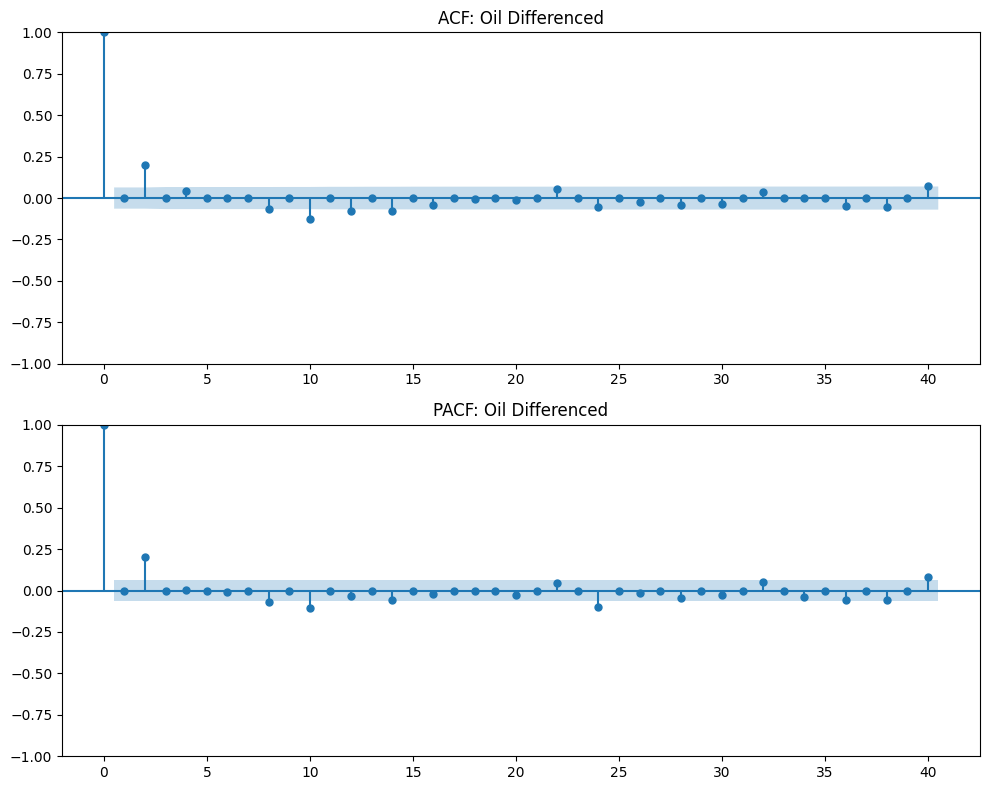

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(inflation_exo['oil_diff'], lags=40, ax=axes[0])
axes[0].set_title('ACF: Oil Differenced')
plot_pacf(inflation_exo['oil_diff'], lags=40, ax=axes[1])
axes[1].set_title('PACF: Oil Differenced')
plt.tight_layout()
plt.show()

### 7.2 M2 Money Supply Differenced - ACF/PACF

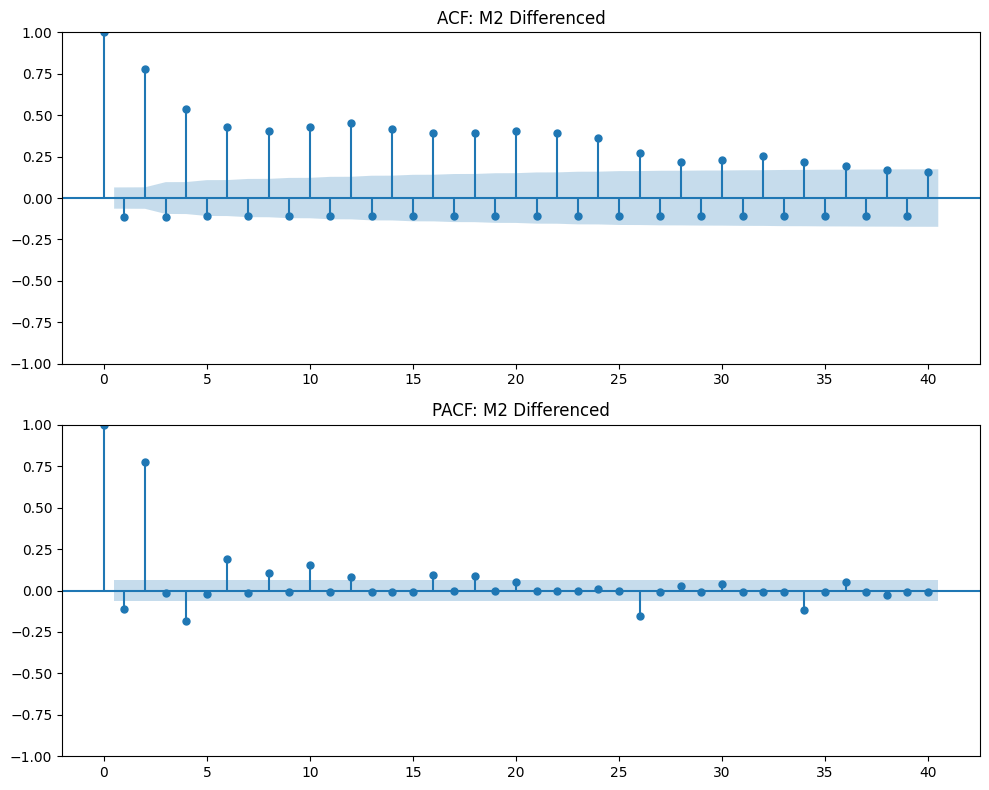

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(inflation_exo['m2_diff'], lags=40, ax=axes[0])
axes[0].set_title('ACF: M2 Differenced')
plot_pacf(inflation_exo['m2_diff'], lags=40, ax=axes[1])
axes[1].set_title('PACF: M2 Differenced')
plt.tight_layout()
plt.show()

## 8. Cross-Correlation Function Analysis

### Data-Driven Lag Selection

Computing Cross-Correlation Functions (CCF) across **25 lag periods** to identify optimal lags where each predictor has the strongest relationship with inflation.

**Method:** For each variable, calculate Pearson correlation between:
- Current inflation (t)
- Lagged predictor (t-lag)

**Interpretation:** Peak correlation indicates optimal predictive lag.

---

### Economic Intuition:
- **Oil:** Energy costs take time to propagate through production chains
- **Unemployment:** Phillips curve operates with minimal lag
- **M2:** Monetary policy transmission has long lags

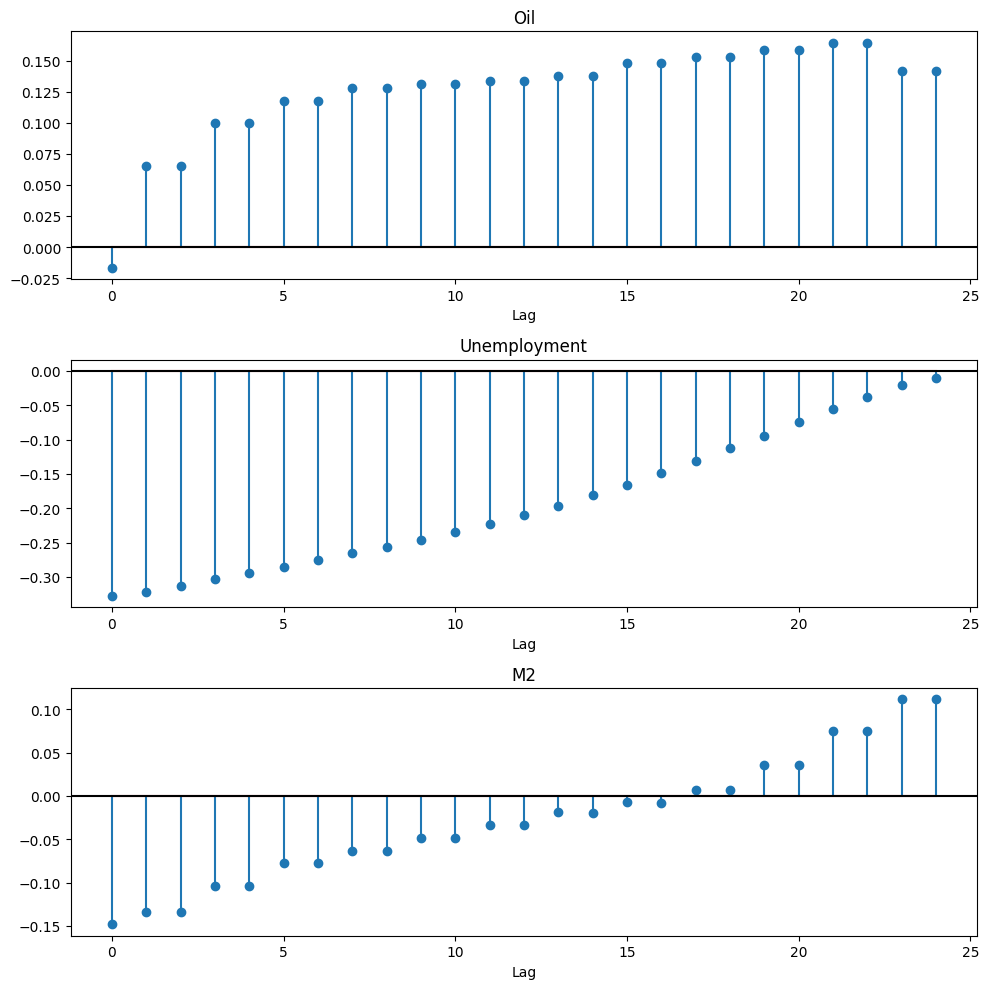

In [13]:
lags = range(0, 25)

oil_ccf = [pearsonr(inflation_exo['inflation'].iloc[lag:], 
                     inflation_exo['oil_diff'].iloc[:-lag] if lag > 0 else inflation_exo['oil_diff'])[0] 
           for lag in lags]

unemployment_ccf = [pearsonr(inflation_exo['inflation'].iloc[lag:], 
                              inflation_exo['unemployment'].iloc[:-lag] if lag > 0 else inflation_exo['unemployment'])[0] 
                    for lag in lags]

m2_ccf = [pearsonr(inflation_exo['inflation'].iloc[lag:], 
                   inflation_exo['m2_diff'].iloc[:-lag] if lag > 0 else inflation_exo['m2_diff'])[0] 
          for lag in lags]


fig, axes = plt.subplots(3, 1, figsize=(10, 10))

axes[0].stem(lags, oil_ccf)
axes[0].set_title('Oil')
axes[0].set_xlabel('Lag')
axes[0].axhline(0, color='black')

axes[1].stem(lags, unemployment_ccf)
axes[1].set_title('Unemployment')
axes[1].set_xlabel('Lag')
axes[1].axhline(0, color='black')

axes[2].stem(lags, m2_ccf)
axes[2].set_title('M2')
axes[2].set_xlabel('Lag')
axes[2].axhline(0, color='black')

plt.tight_layout()
plt.show()

---
## 9. Exploratory Analysis Summary

### Diagnostics Performed

| Category | Tests Conducted | Count |
|----------|----------------|-------|
| **Stationarity Tests** | ADF on inflation, oil, unemployment, m2, oil_diff, m2_diff | 6 |
| **Autocorrelation** | ACF/PACF on inflation (raw & diff), oil_diff, m2_diff | 8 plots |
| **Cross-Correlation** | CCF for oil, unemployment, m2 across 25 lags | 3 × 25 = 75 correlations |

### Key Findings

#### 1. Stationarity Results
- **Inflation:** Exhibits strong autocorrelation and seasonality
-  **Oil:** Non-stationary - Differenced - Stationary
-  **M2:** Highly non-stationary - Differenced - Stationary
-  **Unemployment:** Stationary in levels


#### 2. Economic Interpretation

**Oil Prices:**
- Long lag reflects time for energy cost shocks to propagate through supply chains
- Differenced form captures price changes rather than absolute levels

**Unemployment Rate:**
- Short lag consistent with Phillips curve theory
- Inverse relationship: ↓ unemployment - ↑ wage pressure - ↑ inflation

**M2 Money Supply:**
- Long lag reflects monetary policy transmission mechanism
- Money supply changes take time to affect real economy and prices

### Next Steps

These lag structures will be incorporated into the SARIMAX forecasting model:

```python
SARIMAX(
    endog=inflation,
    exog=[oil_lag_X, unemployment_lag_Y, m2_lag_Z],
    order=(1, 1, 1),
    seasonal_order=(2, 1, 1, 12)
)
```

Where X, Y, Z are the optimal lags identified through CCF analysis.